# **Regular grid model with MODFLOW6**

In [1]:
import matplotlib.pyplot as plt
import os, glob
import numpy as np
import flopy as fp

from definitions import ROOT_DIR, FLOPY_EXEC
from utils.flopy_utils import model_map, cells_coordinates

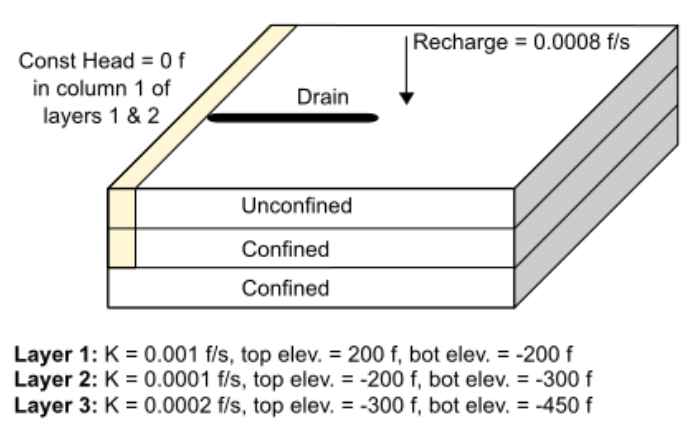

https://s3.eu-west-3.amazonaws.com/gmstutorials-10.5.aquaveo.com/MODFLOW6-GridApproach.pdf

# 1. Model building and simulation

#### Model's parameters

In [2]:
model_name = "mf6_gms-1"
model_files = f"{model_name}_files"

In [3]:
if os.path.isdir(model_files): 
    os.system(f'rm -fr {model_files}')

In [4]:
# aquifer geometry (grid) [units in FEET]

Nlay = 3 # number of layers 
N = 15 # number of rows and columns (subdivisions)
L = 75000.0 # length of model's sides
top = 200 # aquifer top
botm = [-200, -300, -450]

# aquifer parameters
h0 = 1. # starting water head
k1, k2, k3 = .001, .0001, .0002 # horizontal hydraulic conductivity [ft/s]
k33 = 2e-8 # vertical hydraumic conductivity [ft/s]

## Create MODFLOW6 components for a simulation

#### Create a simulation object (SIM)

In [5]:
sim = fp.mf6.MFSimulation(sim_name=model_name, exe_name=f"{FLOPY_EXEC}/mf6", version="mf6", sim_ws=model_files)

#### Create a temporal discretization object (TDIS)

In [6]:
tdis = fp.mf6.ModflowTdis(sim, pname="tdis", time_units="seconds", nper=1, perioddata=[(1.0, 1, 1.0)])
# nper = 1 --> steady-state simulation

#### Create an iterative model solution object (IMS)

In [7]:
ims = fp.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE", linear_acceleration="BICGSTAB")

#### Create a groundwater flow model object (GWF)

In [8]:
nam_file = f"{model_name}.nam"
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file=nam_file, save_flows=True, 
                           newtonoptions="NEWTON UNDER_RELAXATION",)

## Add internal packages to GWF (internal flow of the system)

#### discretization (DIS) Package

In [9]:
bot = np.array(botm) # bottom elevation for each cell
delrow = delcol = L/(N) # row and column spacing
dis = fp.mf6.ModflowGwfdis(gwf, nlay=Nlay, nrow=N, ncol=N, delr=delrow, delc=delcol, top=200, botm=bot,length_units='FEET')

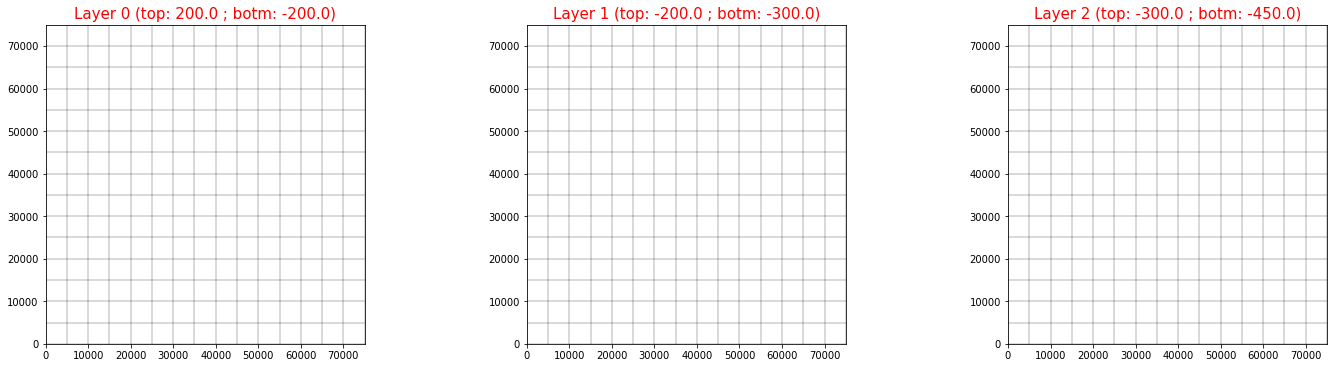

In [10]:
model_map(model=gwf)

## Retrieve all nodes coordinates like [node, (lrc), (xyz)]

In [11]:
cells_coords = cells_coordinates(gwf)

 The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


In [12]:
cells_coords[:10], f'Total_cells: {len(cells_coords)}'

([[660, (2, 14, 0), (2500.0, 2500.0, -375.0)],
  [645, (2, 13, 0), (2500.0, 7500.0, -375.0)],
  [630, (2, 12, 0), (2500.0, 12500.0, -375.0)],
  [615, (2, 11, 0), (2500.0, 17500.0, -375.0)],
  [600, (2, 10, 0), (2500.0, 22500.0, -375.0)],
  [585, (2, 9, 0), (2500.0, 27500.0, -375.0)],
  [570, (2, 8, 0), (2500.0, 32500.0, -375.0)],
  [555, (2, 7, 0), (2500.0, 37500.0, -375.0)],
  [540, (2, 6, 0), (2500.0, 42500.0, -375.0)],
  [525, (2, 5, 0), (2500.0, 47500.0, -375.0)]],
 'Total_cells: 675')

#### initial conditions (IC) Package

In [13]:
start = h0 * np.ones((Nlay, N, N)) # creation of 3D vector filled with h1=100 to represent starting head
#start[:2, 0] = 0.

In [14]:
ic = fp.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

#### node property flow (NPF) Package

In [15]:
npf = fp.mf6.ModflowGwfnpf(gwf, icelltype=[1,0,0], k=[k1, k2, k3], k33=k33) # set cells properties
# icelltype = 1 --> cell is convertible ; 0 --> cell is confined

## Add stress packages to GWF (external flow into/out the system)

#### recharge (RCH) Package

In [16]:
rch = fp.mf6.ModflowGwfrcha(gwf, recharge=3e-8) # recharge rate [ft/s]

In [17]:
rch.recharge.array.shape

(1, 1, 15, 15)

#### constant head (CHD) Package

In [18]:
cells_sel = [i for i in cells_coords if i[1][0] in [0,1] and i[1][2] in [0]] # select all cells in column 0 for 2 first layers

In [19]:
annotations = dict(coords=cells_sel, shift=(-1500, 1000), marker=['x', 'r', 5]) #text=[10, 'r'])

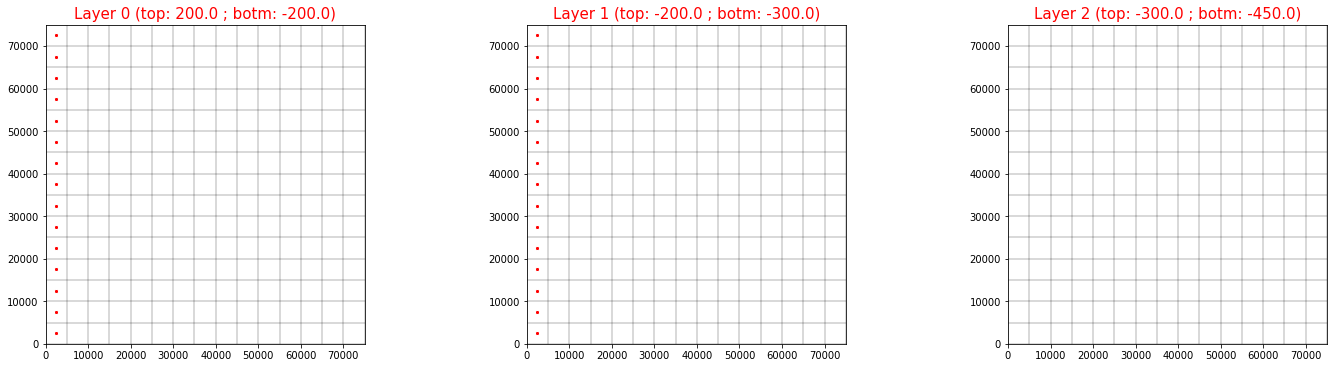

In [20]:
model_map(gwf, annotations=annotations)

In [21]:
# set head to null for selected cells
chd_rec = [(c[1], 0) for c in cells_sel] # ((l,r,c), head)

In [22]:
chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_rec)  # set a constant head stress

In [23]:
# to get a pointer to the recarray (or numpy.recarray) for the first stress period (iper = 0) 
iper = 0 # initial stress period
chd.stress_period_data.get_data(key=iper)

rec.array([((1, 14, 0), 0.), ((1, 13, 0), 0.), ((1, 12, 0), 0.),
           ((1, 11, 0), 0.), ((1, 10, 0), 0.), ((1, 9, 0), 0.),
           ((1, 8, 0), 0.), ((1, 7, 0), 0.), ((1, 6, 0), 0.),
           ((1, 5, 0), 0.), ((1, 4, 0), 0.), ((1, 3, 0), 0.),
           ((1, 2, 0), 0.), ((1, 1, 0), 0.), ((1, 0, 0), 0.),
           ((0, 14, 0), 0.), ((0, 13, 0), 0.), ((0, 12, 0), 0.),
           ((0, 11, 0), 0.), ((0, 10, 0), 0.), ((0, 9, 0), 0.),
           ((0, 8, 0), 0.), ((0, 7, 0), 0.), ((0, 6, 0), 0.),
           ((0, 5, 0), 0.), ((0, 4, 0), 0.), ((0, 3, 0), 0.),
           ((0, 2, 0), 0.), ((0, 1, 0), 0.), ((0, 0, 0), 0.)],
          dtype=[('cellid', 'O'), ('head', '<f8')])

#### drain (DRN) Package

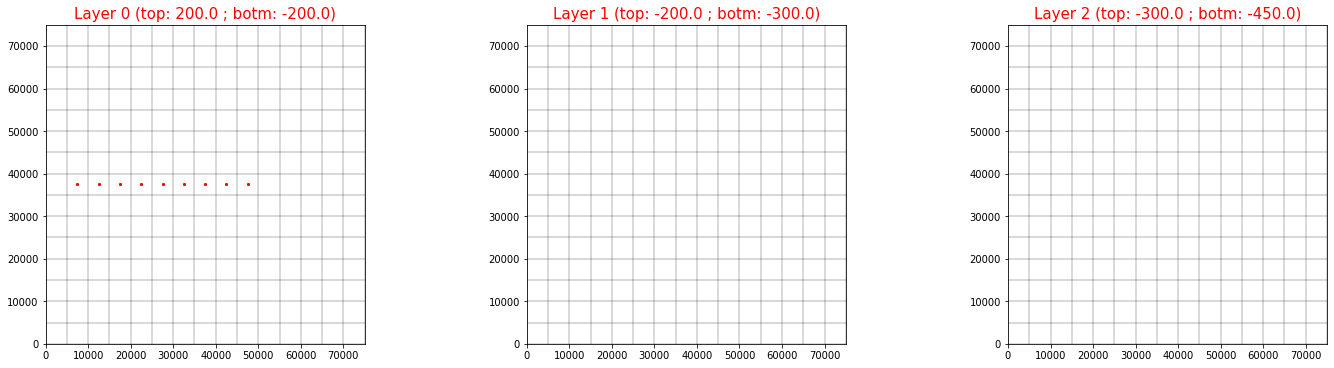

In [24]:
# select cells on row 7 for 1 < column < 8 in first layer
cells_sel = [i for i in cells_coords if i[1][0]==0 and i[1][1]==7 and (i[1][2]>0 and i[1][2]<10)] 
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations)

In [25]:
cond = 1.
elevation = [0, 0, 10, 20, 30, 50, 70, 90, 100]
drn_rec = [(c[1], elv, cond) for c, elv in zip(cells_sel, elevation)] # ((l,r,c), elev, cond)

In [26]:
drn = fp.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_rec)

In [27]:
drn.stress_period_data.array

[rec.array([((0, 7, 1),   0., 1.), ((0, 7, 2),   0., 1.),
            ((0, 7, 3),  10., 1.), ((0, 7, 4),  20., 1.),
            ((0, 7, 5),  30., 1.), ((0, 7, 6),  50., 1.),
            ((0, 7, 7),  70., 1.), ((0, 7, 8),  90., 1.),
            ((0, 7, 9), 100., 1.)],
           dtype=[('cellid', 'O'), ('elev', '<f8'), ('cond', '<f8')])]

#### well (WEL) Package

In [28]:
# cells selection with lrc conditions
cells_sel1 = [i for i in cells_coords if i[1][0]==0 and i[1][1] in [9,11,13] and i[1][2] in [8,10,12,14]]
cells_sel2 = [i for i in cells_coords if i[1][0]==1 and i[1][1] in [4,6] and i[1][2] in [6,12]]
cells_sel3 = [i for i in cells_coords if i[1][0]==2 and i[1][1] in [5,7] and i[1][2] in [2,5,11]]

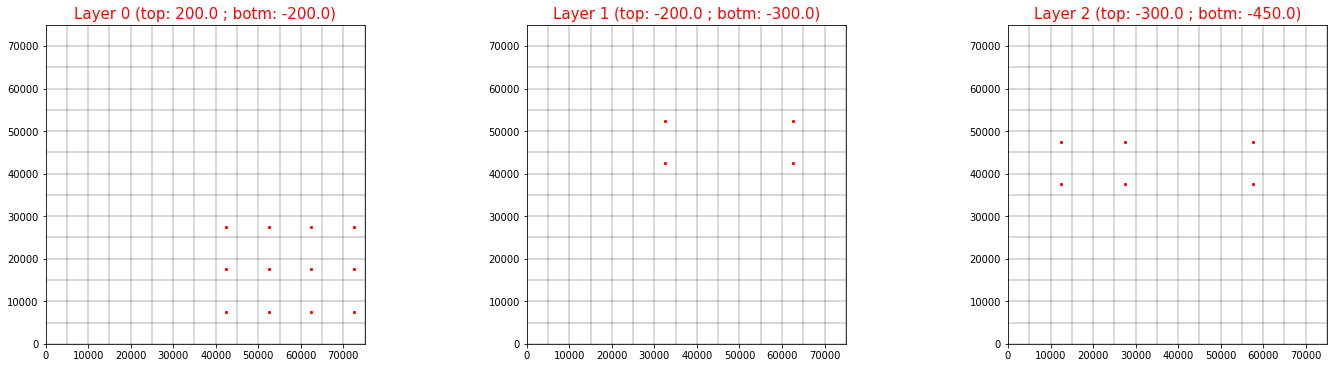

In [29]:
annotations['coords'] = cells_sel1 + cells_sel2 + cells_sel3
model_map(gwf, annotations=annotations)

In [30]:
qp, qi = -1000.0, 2000. # well pumping/injection rate 
wel_rec = [(c[1], qp) for c in cells_sel2+cells_sel3] # ((l,r,c), pump_rate)
wel_rec += [(c[1], qi) for c in cells_sel1] 
wel = fp.mf6.ModflowGwfwel(gwf, stress_period_data=wel_rec)

#### output control (OC) Package

In [31]:
# Save heads and budget output to binary files and print heads to the model listing file at the end of the stress period.
headfile = f"{model_name}.hds" # head information
head_filerecord = [headfile]
budgetfile = f"{model_name}.cbb" # flow terms are written here
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

oc = fp.mf6.ModflowGwfoc(gwf, saverecord=saverecord, head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord, printrecord=printrecord)

## Create the MODFLOW 6 Input Files and Run the Model

### Write the datasets

In [32]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6_gms-1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 30 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 9 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 22 based on size of stress_period_data
    writing package oc...


### Run the simulation

In [33]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: /home/yanathan/Projects/Geotherma/flopy/modules_executables/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 03/08/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Mar 08 2022 20:13:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided o

## Display results

#### Post-process head results

In [34]:
head = gwf.output.head().get_data(kstpkper=(0, 0)) # kstpkper --> k time step, k stress period

#### Map of layers 

In [35]:
kwargs = {'cnt_label':10, 'figsize':(20, 10), 'cb_shrink':0.5, 'cmap':'RdBu'}

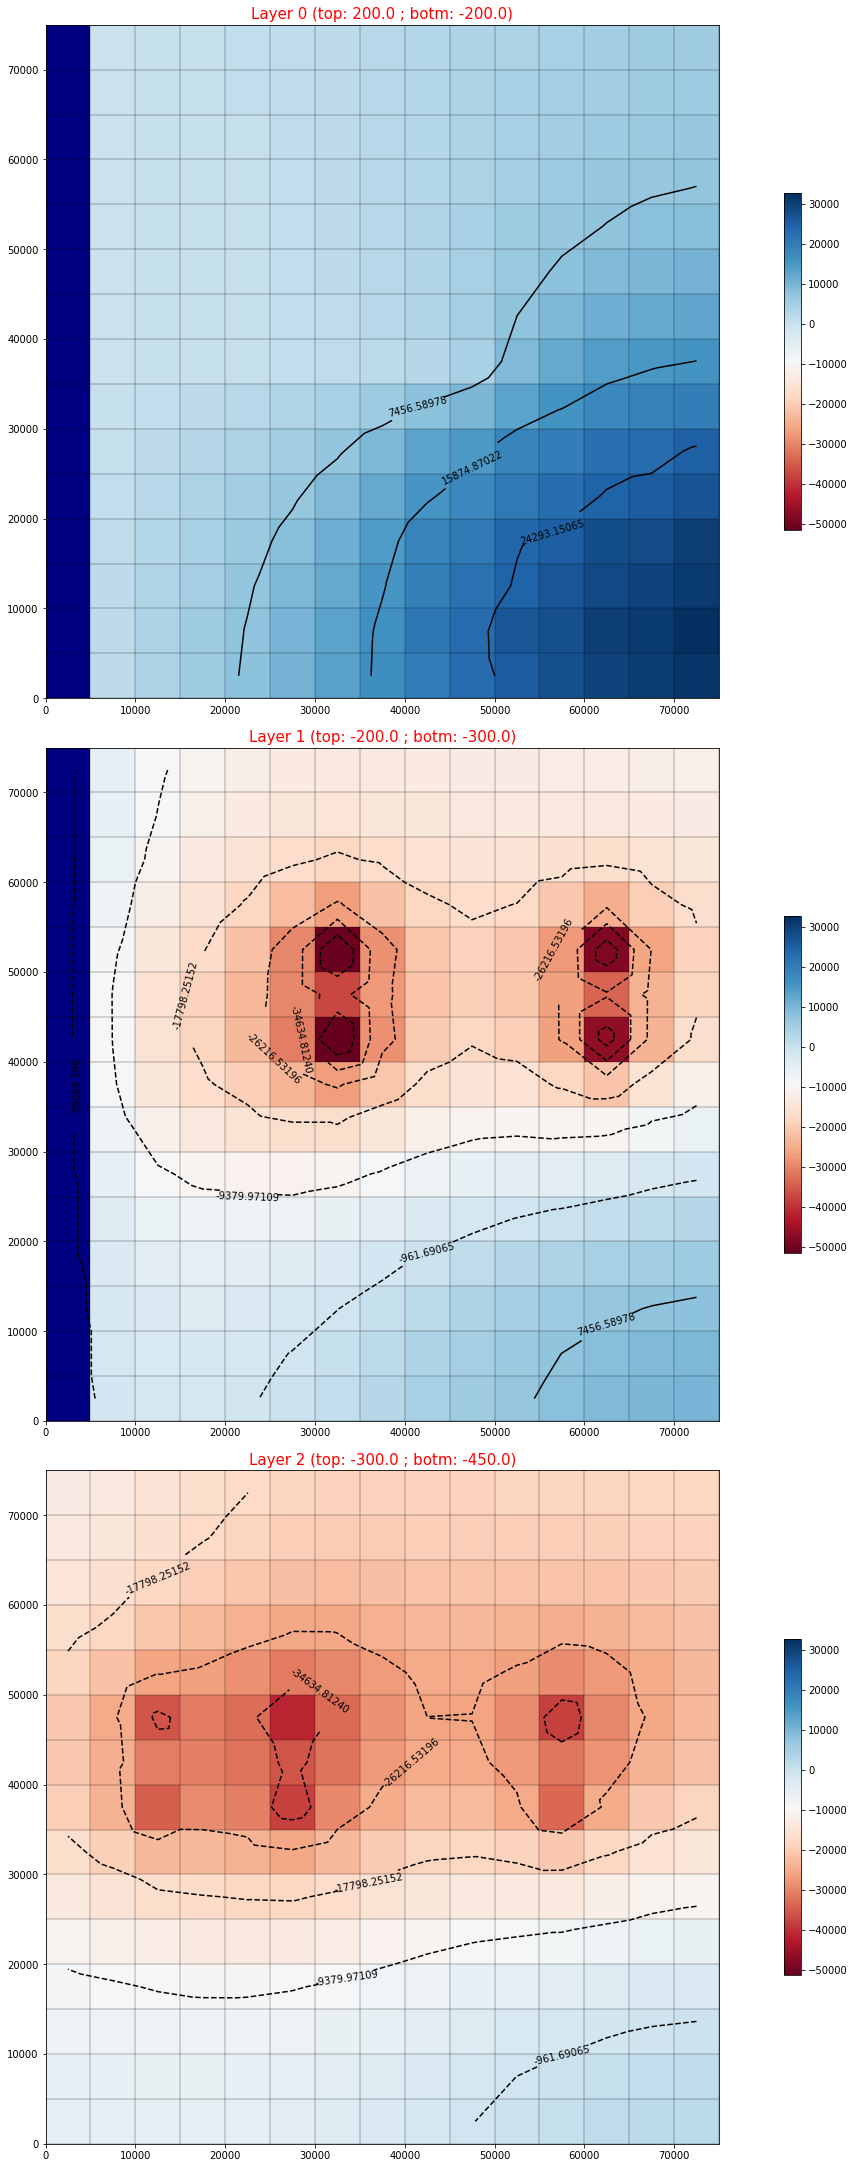

In [36]:
model_map(model=gwf, plot_array=head, layer_line=None, plot_type='map', fig_col=1, **kwargs)

#### Cross-section of heads along rows

Show only row cross-sections stepped by 4 !


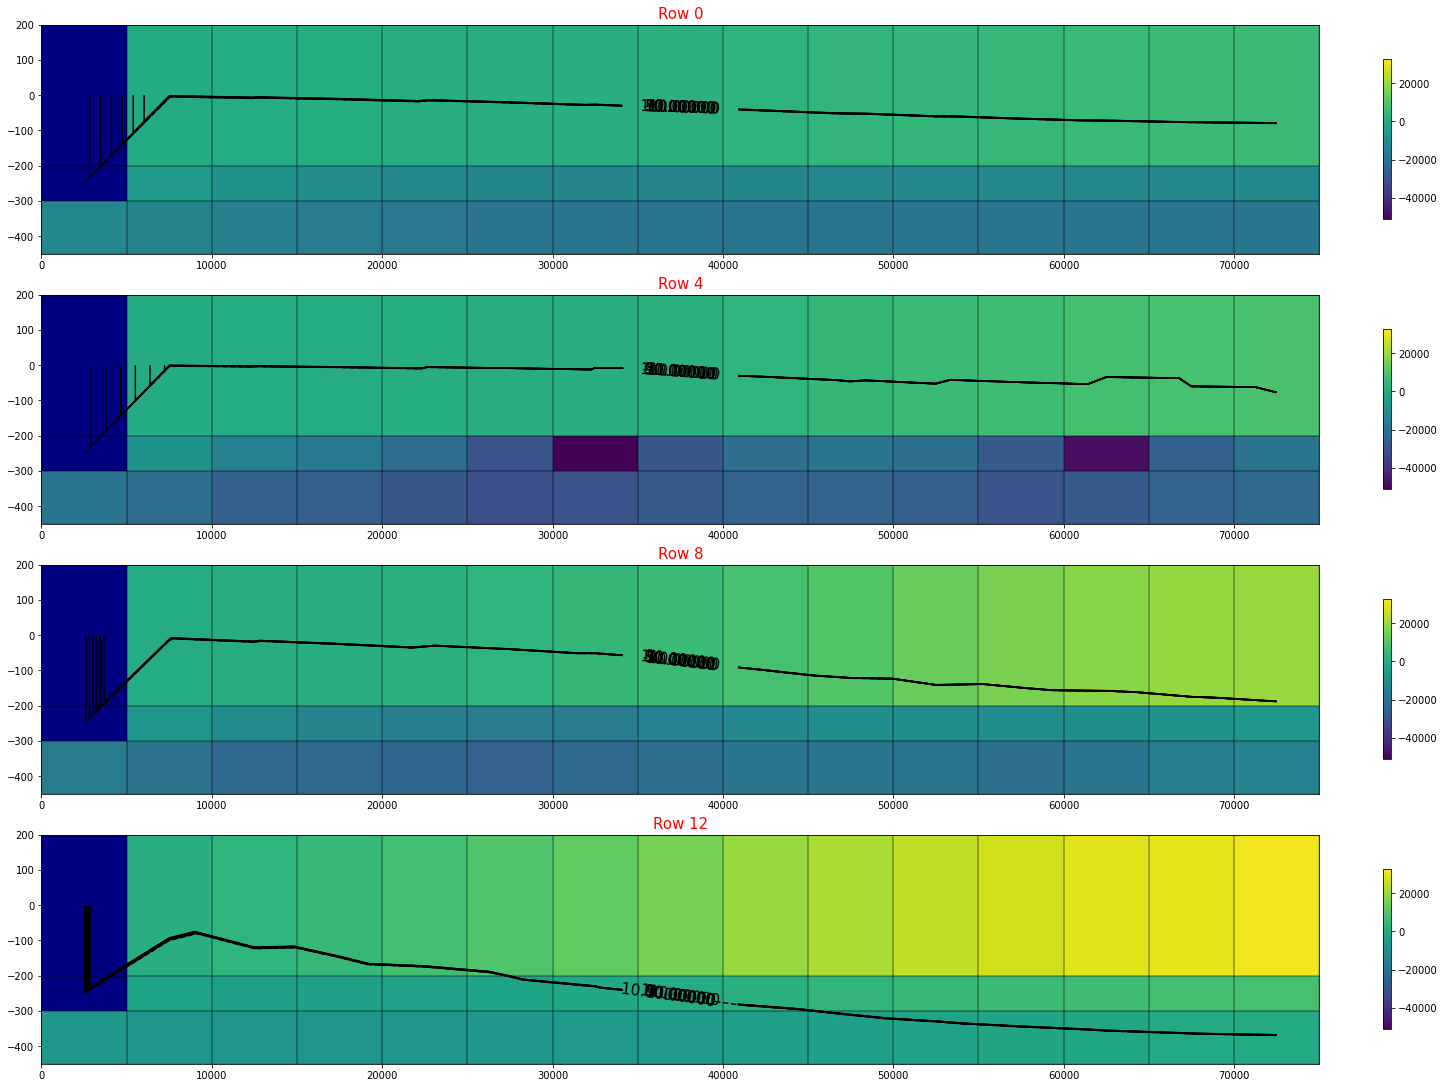

In [37]:
ll = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=ll, plot_type='row', fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'cnt_label':15, 'cnt_intervals':np.arange(-10, 120, 20)})

#### Cross-section of heads along columns

Show only column cross-sections stepped by 4 !


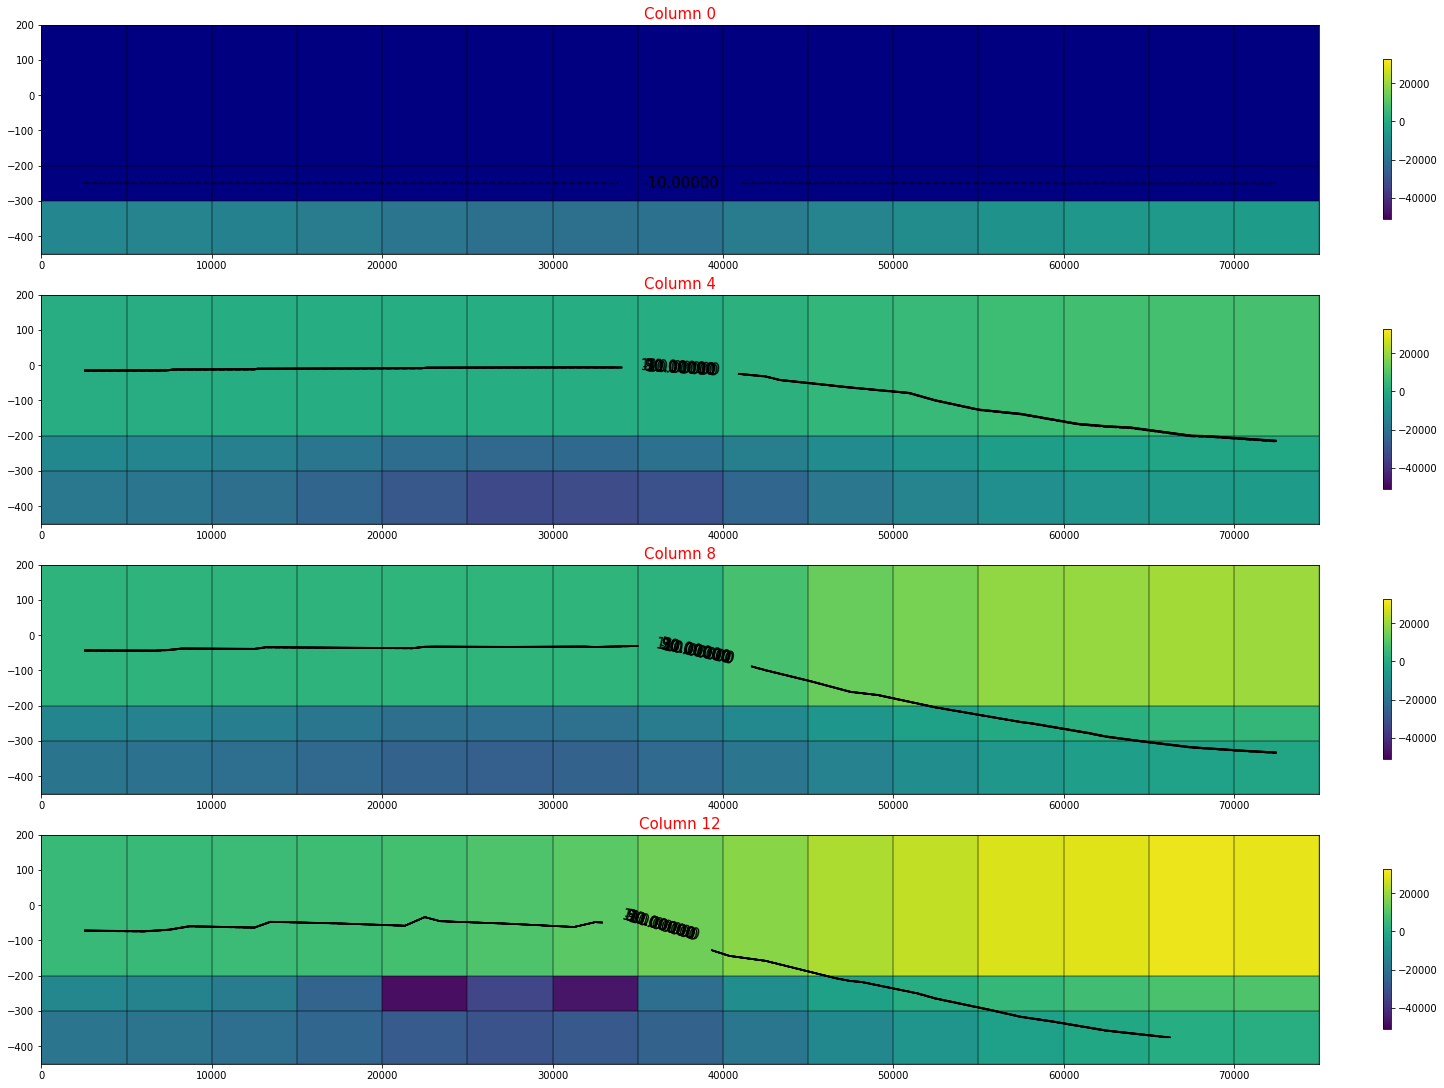

In [38]:
ll = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=ll, plot_type='column', fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'cnt_label':15, 'cnt_intervals':np.arange(-10, 120, 20)})

## Determine the Flow Residual

In [39]:
flowja = gwf.oc.output.budget().get_data(text="FLOW-JA-FACE", kstpkper=(0, 0))[0]

In [40]:
grb_file = f"{model_name}.dis.grb"
residual = fp.mf6.utils.get_residuals(flowja, grb_file=model_files + '/'+ grb_file)

#### Map of the flow error in Layer 10

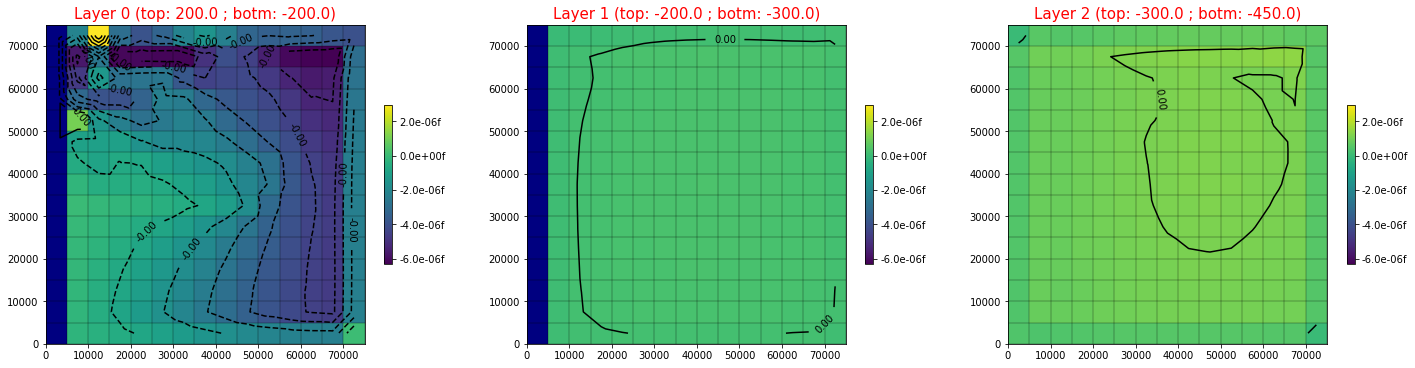

In [42]:
model_map(model=gwf, plot_array=residual, cnt_array=residual, layer_line=None,
            **{'figsize':(20,10), 'cnt_fmt':"%.2f", 'cb_fmt':'%.1ef', 'cb_shrink':0.5})